# Setup packages and GPUs
Uncomment to install following packages in this cell if you needed. If you run in the google colab, seems only need to install segmentation-models-pytorch.

In [58]:
# !pip install -U torch -q
# !pip install -U torchvision -q
!pip install -U segmentation-models-pytorch -q
# !pip install -U matplotlib -q
# !pip install -U Pillow -q
# !pip install numpy==1.23.5 -q
# !pip install -U pandas -q
# !pip install -U scikit-learn -q
# !pip install -U seaborn -q

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import shutil
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import os, warnings
import random
from pathlib import Path
import glob
import pandas as pd
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import sys


warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available, using CPU instead.")

Using device: cuda
CUDA device name: NVIDIA A100-SXM4-40GB


# Import Data

Split the original database into the training, testing and validation sets.
- Build the required directory structure first.

In [60]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset'
splitted_dir = os.path.join(root_dir, "Splitted_database")
os.makedirs(splitted_dir, exist_ok=True)
source_dir = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset'
target_dir = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Splitted_database'
os.makedirs(target_dir, exist_ok=True)
train_dir = os.path.join(target_dir, 'train')
val_dir = os.path.join(target_dir, 'val')
test_dir = os.path.join(target_dir, 'test')
class_names = ['COVID', 'Viral_Pneumonia', 'Normal']

Mounted at /content/drive


Function for splitting the database. Here is the folder structure after splitting:
* **Splitted_database/**
  * **train/** - [70% of data]
    * **COVID/**
      * **images/** - [70% of COVID images]
      * **masks/** - [70% of COVID masks]
    * **Viral_Pneumonia/**
      * **images/** - [70% of Viral_Pneumonia images]
      * **masks/** - [70% of Viral_Pneumonia masks]
    * **Normal/**
      * **images/** - [70% of Normal images]
      * **masks/** - [70% of Normal masks]
  * **val/** - [15% of data]
    * **COVID/**
      * **images/** - [15% of COVID images]
      * **masks/** - [15% of COVID masks]
    * **Viral_Pneumonia/**
      * **images/** - [15% of Viral_Pneumonia images]
      * **masks/** - [15% of Viral_Pneumonia masks]
    * **Normal/**
      * **images/** - [15% of Normal images]
      * **masks/** - [15% of Normal masks]
  * **test/** - [15% of data]
    * **COVID/**
      * **images/** - [15% of COVID images]
      * **masks/** - [15% of COVID masks]
    * **Viral_Pneumonia/**
      * **images/** - [15% of Viral_Pneumonia images]
      * **masks/** - [15% of Viral_Pneumonia masks]
    * **Normal/**
      * **images/** - [15% of Normal images]
      * **masks/** - [15% of Normal masks]

In [61]:
def split_dataset(test_ratio=0.15, val_ratio=0.15, seed=42):
    """
    Split the dataset into training, validation and testing sets while maintaining the folder structure.

    Args:
        source_dir (str): Path to the source dataset directory
        target_dir (str): Path to the target directory where train/val/test will be created
        test_ratio (float): Ratio of test data (default: 0.15)
        val_ratio (float): Ratio of validation data (default: 0.15)
        seed (int): Random seed for reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    # Create the folder structure
    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name, 'images'), exist_ok=True)
        os.makedirs(os.path.join(train_dir, class_name, 'masks'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name, 'images'), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name, 'masks'), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name, 'images'), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name, 'masks'), exist_ok=True)
    for class_name in class_names:
        print(f"Processing {class_name} class...")
        img_dir = os.path.join(source_dir, class_name, 'images')
        mask_dir = os.path.join(source_dir, class_name, 'masks')

        image_files = sorted([f for f in os.listdir(img_dir) if not f.startswith('.') and "(" not in f])
        mask_files = sorted([f for f in os.listdir(mask_dir) if not f.startswith('.') and "(" not in f])
        # Check if the numbers of image and mask are equal
        if len(image_files) != len(mask_files):
            print(f"Warning: Number of images ({len(image_files)}) doesn't match number of masks ({len(mask_files)}) for {class_name}")
        # Paired image with its corresponding masks
        paired_files = []
        for img_file in image_files:
            mask_basename = os.path.splitext(img_file)[0]
            matching_masks = [m for m in mask_files if os.path.splitext(m)[0] == mask_basename]

            if matching_masks:
                paired_files.append((img_file, matching_masks[0]))
            else:
                print(f"Warning: No matching mask found for image {img_file}")
        random.shuffle(paired_files)
        total_count = len(paired_files)
        test_size = int(total_count * test_ratio)
        val_size = int(total_count * val_ratio)
        train_size = total_count - test_size - val_size
        test_pairs = paired_files[:test_size]
        val_pairs = paired_files[test_size:test_size+val_size]
        train_pairs = paired_files[test_size+val_size:]
        print(f"  {class_name}: Total: {total_count}, Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")
        # Load images into new directory in splitted directory
        for img_file, mask_file in train_pairs:
            src_img = os.path.join(source_dir, class_name, 'images', img_file)
            dst_img = os.path.join(train_dir, class_name, 'images', img_file)
            shutil.copy2(src_img, dst_img)
            src_mask = os.path.join(source_dir, class_name, 'masks', mask_file)
            dst_mask = os.path.join(train_dir, class_name, 'masks', mask_file)
            shutil.copy2(src_mask, dst_mask)
        for img_file, mask_file in val_pairs:
            src_img = os.path.join(source_dir, class_name, 'images', img_file)
            dst_img = os.path.join(val_dir, class_name, 'images', img_file)
            shutil.copy2(src_img, dst_img)
            src_mask = os.path.join(source_dir, class_name, 'masks', mask_file)
            dst_mask = os.path.join(val_dir, class_name, 'masks', mask_file)
            shutil.copy2(src_mask, dst_mask)
        for img_file, mask_file in test_pairs:
            src_img = os.path.join(source_dir, class_name, 'images', img_file)
            dst_img = os.path.join(test_dir, class_name, 'images', img_file)
            shutil.copy2(src_img, dst_img)
            src_mask = os.path.join(source_dir, class_name, 'masks', mask_file)
            dst_mask = os.path.join(test_dir, class_name, 'masks', mask_file)
            shutil.copy2(src_mask, dst_mask)
    print("Dataset splitting complete!")
    # Print dataset structure
    print("\nDataset Structure:")
    print("-" * 60)
    print("Class       | Train Images | Valid Images  | Test Images | Total")
    print("-" * 60)
    total_train = 0
    total_val = 0
    total_test = 0
    for class_name in class_names:
        train_count = len(os.listdir(os.path.join(train_dir, class_name, 'images')))
        val_count = len(os.listdir(os.path.join(val_dir, class_name, 'images')))
        test_count = len(os.listdir(os.path.join(test_dir, class_name, 'images')))
        total = train_count + val_count + test_count
        print(f"{class_name:<12}| {train_count:<13}| {val_count:<12}| {test_count:<12}| {total}")
        total_train += train_count
        total_val += val_count
        total_test += test_count
    print("-" * 60)
    print(f"Total       | {total_train:<13}| {total_val:<12}| {total_test:<12}| {total_train + total_val + total_test}")
    print("-" * 60)

In [62]:
# Except the first time or the dataset not splitted as expect, don't run this line:
# split_dataset(test_ratio=0.15, val_ratio=0.15)

Check if the database is splitted as expected data proportion(Here is test/valdation/train = 15%/15%/70%), pairred masks and structure.   
This step is to check the last step is finished or not (cuz take too long time last step).

In [63]:
def count_files(directory):
    """Count the number of files in a directory."""
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])


def validate_split(base_path):
    # if new split method (as 10/10/80) should change here:
    expected_counts = {
        'COVID': {'total': 3616, 'train': 2532, 'val': 542, 'test': 542},
        'Viral_Pneumonia': {'total': 1345, 'train': 943, 'val': 201, 'test': 201},
        'Normal': {'total': 10192, 'train': 7136, 'val': 1528, 'test': 1528}
    }
    actual_counts = {
        'COVID': {'train_images': 0, 'train_masks': 0,
                  'val_images': 0, 'val_masks': 0,
                  'test_images': 0, 'test_masks': 0},
        'Viral_Pneumonia': {'train_images': 0, 'train_masks': 0,
                           'val_images': 0, 'val_masks': 0,
                           'test_images': 0, 'test_masks': 0},
        'Normal': {'train_images': 0, 'train_masks': 0,
                  'val_images': 0, 'val_masks': 0,
                  'test_images': 0, 'test_masks': 0}
    }
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"Warning: Split directory '{split_path}' does not exist.")
            continue

        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: Class directory '{class_path}' does not exist.")
                continue

            images_path = os.path.join(class_path, 'images')
            masks_path = os.path.join(class_path, 'masks')

            if os.path.exists(images_path):
                actual_counts[class_name][f'{split}_images'] = count_files(images_path)
            else:
                print(f"Warning: Images directory '{images_path}' does not exist.")

            if os.path.exists(masks_path):
                actual_counts[class_name][f'{split}_masks'] = count_files(masks_path)
            else:
                print(f"Warning: Masks directory '{masks_path}' does not exist.")
    results = []

    for class_name, counts in actual_counts.items():
        train_images = counts['train_images']
        val_images = counts['val_images']
        test_images = counts['test_images']
        total_images = train_images + val_images + test_images

        train_masks = counts['train_masks']
        val_masks = counts['val_masks']
        test_masks = counts['test_masks']
        total_masks = train_masks + val_masks + test_masks

        expected = expected_counts[class_name]
        images_match = (
            train_images == expected['train'] and
            val_images == expected['val'] and
            test_images == expected['test'] and
            total_images == expected['total']
        )
        masks_match_images = (
            train_masks == train_images and
            val_masks == val_images and
            test_masks == test_images and
            total_masks == total_images
        )
        train_pct = round(train_images / total_images * 100, 1) if total_images > 0 else 0
        val_pct = round(val_images / total_images * 100, 1) if total_images > 0 else 0
        test_pct = round(test_images / total_images * 100, 1) if total_images > 0 else 0
        results.append({
            'Class': class_name,
            'Train Images': train_images,
            'Val Images': val_images,
            'Test Images': test_images,
            'Total Images': total_images,
            'Train %': train_pct,
            'Val %': val_pct,
            'Test %': test_pct,
            'Train Masks': train_masks,
            'Val Masks': val_masks,
            'Test Masks': test_masks,
            'Total Masks': total_masks,
            'Expected Train': expected['train'],
            'Expected Val': expected['val'],
            'Expected Test': expected['test'],
            'Expected Total': expected['total'],
            'Images Match Expected': images_match,
            'Masks Match Images': masks_match_images
        })
    df = pd.DataFrame(results)
    print("\n=== Dataset Split Validation Results ===\n")
    print(df[['Class', 'Train Images', 'Train %', 'Val Images', 'Val %', 'Test Images', 'Test %', 'Total Images',
              'Images Match Expected', 'Masks Match Images']])
    mismatches = df[~df['Images Match Expected'] | ~df['Masks Match Images']]
    if not mismatches.empty:
        print("\n=== Detailed Analysis for Mismatches ===\n")
        for _, row in mismatches.iterrows():
            class_name = row['Class']
            print(f"Class: {class_name}")

            if not row['Images Match Expected']:
                print("  Image count mismatch:")
                print(f"    Train: {row['Train Images']} (Expected: {row['Expected Train']})")
                print(f"    Val: {row['Val Images']} (Expected: {row['Expected Val']})")
                print(f"    Test: {row['Test Images']} (Expected: {row['Expected Test']})")
                print(f"    Total: {row['Total Images']} (Expected: {row['Expected Total']})")

            if not row['Masks Match Images']:
                print("  Mask-Image count mismatch:")
                print(f"    Train: {row['Train Masks']} masks vs {row['Train Images']} images")
                print(f"    Val: {row['Val Masks']} masks vs {row['Val Images']} images")
                print(f"    Test: {row['Test Masks']} masks vs {row['Test Images']} images")
                print(f"    Total: {row['Total Masks']} masks vs {row['Total Images']} images")
            print()
    else:
        print("\nAll classes have correct splits and matching masks/images counts! ✓")
    overall_correct_split = True
    for _, row in df.iterrows():
        # if new split method (as 10/10/80) should change here also:
        if abs(row['Train %'] - 70) > 1 or abs(row['Val %'] - 15) > 1 or abs(row['Test %'] - 15) > 1:
            overall_correct_split = False
    if overall_correct_split:
        print("\nSplit Correctly!")
    else:
        print("\nWarning: The distribution doesn't match the expected distribution!!!")
    return df

In [64]:
results = validate_split(splitted_dir)


=== Dataset Split Validation Results ===

             Class  Train Images  Train %  Val Images  Val %  Test Images  \
0            COVID          2532     70.0         542   15.0          542   
1  Viral_Pneumonia           943     70.1         201   14.9          201   
2           Normal          7136     70.0        1528   15.0         1528   

   Test %  Total Images  Images Match Expected  Masks Match Images  
0    15.0          3616                   True                True  
1    14.9          1345                   True                True  
2    15.0         10192                   True                True  

All classes have correct splits and matching masks/images counts! ✓

Split Correctly!


load data and apply data pre-processing steps on it.

In [65]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class_types = ['train', 'val', 'test']
def data_pre_processing(img_path, mask_path):
    try:
        # Normalization Config from ImageNet based models
        # original resoulution is 299 x 299
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        img_tensor = transform(img).to(device)
        mask = mask.resize((128, 128), Image.NEAREST)
        mask_temsor = TF.to_tensor(mask).to(device)
        mask_temsor = (mask_temsor > 0.5).float()
    except Exception as e:
        print(f"Error processing {img_path} and {mask_path}: {e}")
        return None, None
    return img_tensor, mask_temsor

In [66]:
from enum import unique
class_map = {'COVID': 0, 'Viral_Pneumonia': 1, 'Normal': 2}
dataloaders = {}
# only shuffle the training set
for class_l in class_types:
    images = []
    masks = []
    labels = []
    cur_class_path = os.path.join(target_dir, class_l)
    if not os.path.exists(cur_class_path):
        print(f"Warning! {cur_class_path} does not exists!")
        break
    else:
        print(cur_class_path)
        for class_name in class_map.keys():
            class_dir = os.path.join(cur_class_path, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning! {class_dir} does not exists!")
                break
            else:
                image_dir = os.path.join(class_dir, 'images')
                mask_dir = os.path.join(class_dir, 'masks')
                if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
                    print(f"Warning! {image_dir} or {mask_dir} does not exists!")
                    break
                else:
                    image_files = glob.glob(os.path.join(image_dir, '*'))
                    # Reduce the dataset size to 1/10 since training time too long
                    random.seed(42)
                    subset_size = max(len(image_files) // 5, 1)
                    sampled_image_files = random.sample(image_files, subset_size)
                    print(f"Sampling {subset_size}/{len(image_files)} images from {class_name} in {class_l}")
                    for img_path in sampled_image_files:
                        # get the correspounding mask file
                        # the mask and the correspounding original image has the same name
                        img_filename = os.path.basename(img_path)
                        mask_path = os.path.join(mask_dir, img_filename)
                        if os.path.exists(mask_path):
                            img_tensor, mask_tensor = data_pre_processing(img_path, mask_path)
                            if img_tensor is not None and mask_tensor is not None:
                                images.append(img_tensor)
                                masks.append(mask_tensor)
                                labels.append(class_map[class_name])

        if images:
            print(f"{class_l} loaded {len(images)} samples")
            images_tensor = torch.stack(images)
            masks_tensor = torch.stack(masks)
            labels_tensor = torch.tensor(labels)
            # check distribution
            unique_labels, counts = torch.unique(labels_tensor, return_counts=True)
            distribution = {list(class_map.keys())[l.item()]: c.item() for l, c in zip(unique_labels, counts)}
            print(f"Class distribution in {class_l}: {distribution}")
            dataset = TensorDataset(images_tensor, masks_tensor, labels_tensor)
            shuffle = (class_l == 'train')
            dataloaders[class_l] = DataLoader(dataset, batch_size=16, shuffle=shuffle)
        else:
            print(f"No images found in {class_l}, please check code + data folder again")
            break

/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Splitted_database/train
Sampling 506/2532 images from COVID in train
Sampling 188/943 images from Viral_Pneumonia in train
Sampling 1427/7136 images from Normal in train
train loaded 2121 samples
Class distribution in train: {'COVID': 506, 'Viral_Pneumonia': 188, 'Normal': 1427}
/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Splitted_database/val
Sampling 108/542 images from COVID in val
Sampling 40/201 images from Viral_Pneumonia in val
Sampling 305/1528 images from Normal in val
val loaded 453 samples
Class distribution in val: {'COVID': 108, 'Viral_Pneumonia': 40, 'Normal': 305}
/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Splitted_database/test
Sampling 108/542 images from COVID in test
Sampling 40/201 images from Viral_Pneumonia in test
Sampling 305/1528 images from Normal in test
test loaded 453 samples
Class distribution in test: {'COVID': 108, 'Viral_Pneumonia':

Show a batch of the sample.

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7b30883f3e90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7b303dbd6a50>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7b303ec4b490>}
Images device: cuda:0, Masks device: cuda:0, Labels device: cpu


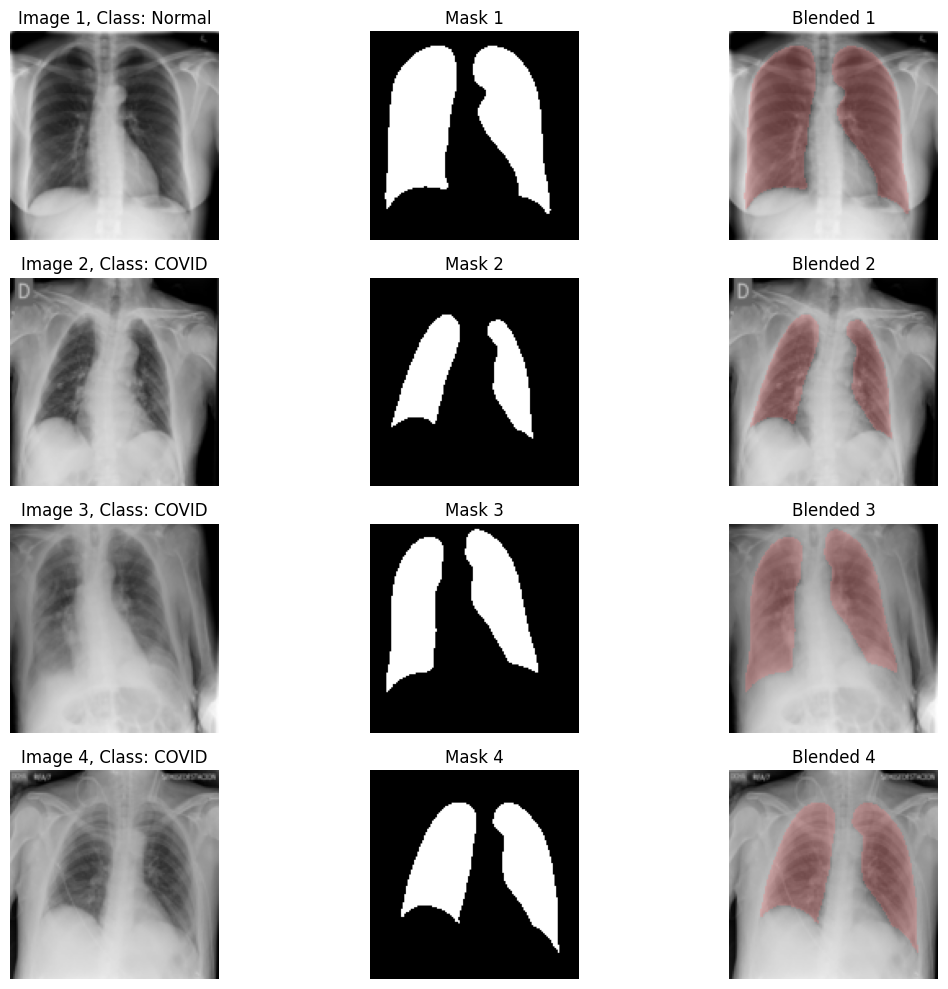

In [67]:
print(dataloaders)
images, masks, labels = next(iter(dataloaders['train']))
print(f"Images device: {images.device}, Masks device: {masks.device}, Labels device: {labels.device}")
mean = torch.tensor(mean, device=images.device).view(1, 3, 1, 1)
std = torch.tensor(std, device=images.device).view(1, 3, 1, 1)
images_display = (images * std) + mean
images_display = images_display.clamp(0, 1)
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
# only display first four
for i in range(4):
    img = images_display[i].permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Image {i+1}, Class: {list(class_map.keys())[labels[i]]}')
    axes[i, 0].axis('off')
    # Squeeze the mask tensor to remove the single-dimension at the beginning
    mask_np = masks[i].squeeze().cpu().numpy()
    axes[i, 1].imshow(mask_np, cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1}')
    axes[i, 1].axis('off')
    overlay = img.copy()
    # show mask as a red overlay layer
    for c in range(3):
        channel_overlay = overlay[:, :, c].copy()
        if c == 0:
            channel_overlay[mask_np > 0.5] = 1.0
        else:
            channel_overlay[mask_np > 0.5] = 0.5
        overlay[:, :, c] = channel_overlay
    alpha = 0.3
    blended = (1-alpha) * img + alpha * overlay
    axes[i, 2].imshow(blended)
    axes[i, 2].set_title(f'Blended {i+1}')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

# Create the model

Loss function Combination.

In [68]:
# loss weight should be [seg_weight:cls_weight] to define which event is more important
def loss_function(seg_pred, cls_pred, seg_true, cls_true, loss_weight):
    device = seg_pred.device
    seg_true = seg_true.to(device)
    cls_true = cls_true.to(device)
    seg_criterion = nn.BCELoss().to(device)
    cls_criterion = nn.CrossEntropyLoss().to(device)
    seg_loss = seg_criterion(seg_pred, seg_true)
    cls_loss = cls_criterion(cls_pred, cls_true)
    total_loss = seg_loss * loss_weight[0] + cls_loss * loss_weight[1]
    return total_loss, seg_loss, cls_loss

In [69]:
def create_combined_model(num_classes):
    unet_model = smp.Unet(
        encoder_name="resnet18",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation="sigmoid"
    ).to(device)
    resnet18_model = torchvision.models.resnet18(weights="IMAGENET1K_V1").to(device)
    original_conv = resnet18_model.conv1
    resnet18_model.conv1 = nn.Conv2d(
        4,
        original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias is not None
    ).to(device)
    with torch.no_grad():
        resnet18_model.conv1.weight[:, :3] = original_conv.weight
    num_ftrs = resnet18_model.fc.in_features
    resnet18_model.fc = nn.Linear(num_ftrs, num_classes).to(device)
    # forward propagation function
    # x = input image tensor
    def forward_fn(x):
        x = x.to(device)
        mask = unet_model(x)
        x_combine = torch.cat((x, mask), dim=1)
        classification = resnet18_model(x_combine)
        return mask, classification
    return forward_fn, (unet_model, resnet18_model)

# Training the Model

In [70]:
def train_model(forward_fn, models, dataloaders, optimizer, loss_weight, scheduler=None, num_epochs=25, patience=5):
    # preparation stage
    seg_model, classify_model = models
    seg_model = seg_model.to(device)
    classify_model = classify_model.to(device)
    print(f"Segmentation model device: {next(seg_model.parameters()).device}")
    print(f"Classification model device: {next(classify_model.parameters()).device}")
    best_seg_state = copy.deepcopy(seg_model.state_dict())
    best_cls_state = copy.deepcopy(classify_model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_seg_loss': [], 'val_seg_loss': [],
        'train_cls_loss': [], 'val_cls_loss': [],
        'train_acc': [], 'val_acc': []
    }
    counter = 0
    # training stage
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                seg_model.train()
                classify_model.train()
            else:
                seg_model.eval()
                classify_model.eval()
            running_loss = 0.0
            running_seg_loss = 0.0
            running_cls_loss = 0.0
            running_corrects = 0
            for inputs, masks, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    mask_preds, class_preds = forward_fn(inputs)
                    loss, seg_loss, cls_loss = loss_function(mask_preds, class_preds, masks, labels, loss_weight)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_seg_loss += seg_loss.item() * inputs.size(0)
                running_cls_loss += cls_loss.item() * inputs.size(0)
                _, preds = torch.max(class_preds, 1)
                running_corrects += torch.sum(preds == labels.data)
            dataset_size = len(dataloaders[phase].dataset)
            epoch_loss = running_loss / dataset_size
            epoch_seg_loss = running_seg_loss / dataset_size
            epoch_cls_loss = running_cls_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if scheduler is not None and phase == 'train':
                scheduler.step()
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_seg_loss'].append(epoch_seg_loss)
            history[f'{phase}_cls_loss'].append(epoch_cls_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Seg Loss: {epoch_seg_loss:.4f} Cls Loss: {epoch_cls_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_seg_state = copy.deepcopy(seg_model.state_dict())
                best_cls_state = copy.deepcopy(classify_model.state_dict())
                counter = 0
            elif phase == 'val':
                counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    print(f'Best validation accuracy: {best_acc:.4f} at epoch {best_epoch}')
    return (best_seg_state, best_cls_state), history

# Visualization

In [71]:
def plot_training_history(history):
    # Testing
    train_length = len(history['train_loss'])
    train_epochs = range(1, train_length + 1)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(train_epochs, history['train_loss'], 'b-')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 2)
    plt.plot(train_epochs, history['train_seg_loss'], 'g-')
    plt.title('Training Segmentation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 3)
    plt.plot(train_epochs, history['train_cls_loss'], 'r-')
    plt.title('Training Classification Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 4)
    plt.plot(train_epochs, history['train_acc'], 'y-')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    # Validation
    val_length = len(history['val_loss'])
    val_epochs = range(1, val_length + 1)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(val_epochs, history['val_loss'], 'b-')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 2)
    plt.plot(val_epochs, history['val_seg_loss'], 'g-')
    plt.title('Validation Segmentation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 3)
    plt.plot(val_epochs, history['val_cls_loss'], 'r-')
    plt.title('Validation Classification Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(2, 2, 4)
    plt.plot(val_epochs, history['val_acc'], 'y-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

In [72]:
# def plot_training_history(history):
#     actual_epochs = len(history['train_loss'])
#     epochs = range(1, actual_epochs + 1)
#     fig, axs = plt.subplots(2, 2, figsize=(15, 10))
#     # total loss
#     axs[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
#     axs[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
#     axs[0, 0].set_xlabel('Epochs')
#     axs[0, 0].set_ylabel('Loss')
#     axs[0, 0].set_title('Total Loss')
#     axs[0, 0].legend()
#     # segmentation loss
#     axs[0, 1].plot(epochs, history['train_seg_loss'], 'b-', label='Train Seg Loss')
#     axs[0, 1].plot(epochs, history['val_seg_loss'], 'r-', label='Validation Seg Loss')
#     axs[0, 1].set_xlabel('Epochs')
#     axs[0, 1].set_ylabel('Loss')
#     axs[0, 1].set_title('Segmentation Loss')
#     axs[0, 1].legend()
#     # classification loss
#     axs[1, 0].plot(epochs, history['train_cls_loss'], 'b-', label='Train Cls Loss')
#     axs[1, 0].plot(epochs, history['val_cls_loss'], 'r-', label='Validation Cls Loss')
#     axs[1, 0].set_xlabel('Epochs')
#     axs[1, 0].set_ylabel('Loss')
#     axs[1, 0].set_title('Classification Loss')
#     axs[1, 0].legend()
#     # Accuracy
#     axs[1, 1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
#     axs[1, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
#     axs[1, 1].set_xlabel('Epochs')
#     axs[1, 1].set_ylabel('Accuracy')
#     axs[1, 1].set_title('Accuracy')
#     axs[1, 1].legend()
#     plt.tight_layout()
#     plt.show()
#     print(f"Actual Training Epochs: {actual_epochs}")

def plot_predictions(foward_pf, models, num_samples=6):
    seg_model, classify_model = models
    test_loader = dataloaders['test']
    seg_model.eval()
    classify_model.eval()
    inputs, masks, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    masks = masks.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        mask_preds, outputs = foward_pf(inputs.to(device))
        _, preds = torch.max(outputs, 1)
    inputs_display = (inputs * std) + mean
    images_np = inputs_display.permute(0, 2, 3, 1).cpu().numpy()
    masks_np = masks.cpu().numpy()
    mask_preds_np = mask_preds.cpu().numpy()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 25))
    for i in range(num_samples):
        axes[i, 0].imshow(images_np[i])
        axes[i, 0].set_title(f'Groud Truth Image {class_names[labels[i]]}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(masks_np[i][0], cmap='gray')
        axes[i, 1].set_title(f'Ground Truth Mask {class_names[labels[i]]}')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(mask_preds_np[i][0], cmap='gray')
        axes[i, 2].set_title(f'Predicted Mask {class_names[preds[i]]}')
        axes[i, 2].axis('off')
        color = 'green' if preds[i] == labels[i] else 'red'
        for j in range(3):
            axes[i, j].spines['bottom'].set_color(color)
            axes[i, j].spines['top'].set_color(color)
            axes[i, j].spines['left'].set_color(color)
            axes[i, j].spines['right'].set_color(color)
            axes[i, j].spines['bottom'].set_linewidth(5)
            axes[i, j].spines['top'].set_linewidth(5)
            axes[i, j].spines['left'].set_linewidth(5)
            axes[i, j].spines['right'].set_linewidth(5)
    plt.tight_layout()
    plt.show()

# Evaluation
Involve a part of the visualization.

In [78]:
def evaluate_model(forward_fn, models):
    test_loader = dataloaders['test']
    seg_model, classify_model = models
    seg_model = seg_model.to(device)
    classify_model = classify_model.to(device)
    seg_model.eval()
    classify_model.eval()
    y_true = []
    y_pred = []
    dice_scores = []
    vis_samples = []
    with torch.no_grad():
        for inputs, masks, labels in test_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            mask_preds, outputs = forward_fn(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            # Calculate the dice score for each image
            pred_masks_binary = (mask_preds > 0.5).float()
            true_masks_binary = (masks > 0.5).float()
            for i in range(inputs.size(0)):
                intersection = torch.sum(pred_masks_binary[i] * true_masks_binary[i]) * 2.0
                union = torch.sum(pred_masks_binary[i]) + torch.sum(true_masks_binary[i])
                if union == 0:
                    if intersection == 0:
                        dice = torch.tensor(1.0, device=device)
                    else:
                        dice = torch.tensor(0.0, device=device)
                else:
                    dice = intersection / union
                dice_scores.append(dice.cpu().item())
                if len(vis_samples) < 10 and random.random() < 0.1:
                    vis_samples.append({
                        'input': inputs[i].cpu(),
                        'pred_mask': pred_masks_binary[i].cpu(),
                        'true_mask': true_masks_binary[i].cpu(),
                        'dice': dice.cpu().item(),
                        'class_true': labels[i].cpu().item(),
                        'class_pred': preds[i].cpu().item()
                    })
    mean_dice = np.mean(dice_scores)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(class_report)
    print(f"\nSegmentation Results:")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # Dice Score Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(dice_scores, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(mean_dice, color='red', linestyle='dashed', linewidth=2, label=f'Mean Dice: {mean_dice:.4f}')
    plt.title('Distribution of Dice Scores')
    plt.xlabel('Dice Coefficient')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    if vis_samples:
        # Denormalization
        mean_tensor = torch.tensor(mean, device='cpu').view(3, 1, 1)
        std_tensor = torch.tensor(std, device='cpu').view(3, 1, 1)
        denormalize = lambda x: x * std_tensor + mean_tensor
        num_samples = len(vis_samples)
        if num_samples == 1:
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        else:
            fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
        for i, sample in enumerate(vis_samples):
            img = denormalize(sample['input']).permute(1, 2, 0).numpy()
            pred_mask = sample['pred_mask'][0].numpy()
            true_mask = sample['true_mask'][0].numpy()
            dice_score = sample['dice']
            class_true = int(sample['class_true'])
            class_pred = int(sample['class_pred'])
            if num_samples == 1:
                current_axes = axes
            else:
                current_axes = axes[i]
            current_axes[0].imshow(img)
            current_axes[0].set_title(f"Original Image\nTrue: {class_names[class_true]}, Pred: {class_names[class_pred]}")
            current_axes[0].axis('off')
            current_axes[1].imshow(pred_mask, cmap='gray')
            current_axes[1].set_title("Prediction Mask")
            current_axes[1].axis('off')
            current_axes[2].imshow(true_mask, cmap='gray')
            current_axes[2].set_title("Ground Truth Mask")
            current_axes[2].axis('off')
            overlap = np.zeros((img.shape[0], img.shape[1], 3))
            # TP for green
            tp = np.logical_and(pred_mask, true_mask)
            overlap[tp, 1] = 1.0
            # FP for red
            fp = np.logical_and(pred_mask, np.logical_not(true_mask))
            overlap[fp, 0] = 1.0
            # FN for blue
            fn = np.logical_and(np.logical_not(pred_mask), true_mask)
            overlap[fn, 2] = 1.0
            current_axes[3].imshow(overlap)
            current_axes[3].set_title(f"Overlap (Green=TP, Red=FP, Blue=FN)\nDice: {dice_score:.4f}")
            current_axes[3].axis('off')
        plt.tight_layout()
        plt.show()
    # Accuracy
    accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"Classification Accuracy: {accuracy:.4f}")

# Execution

train: 3 samples
val: 3 samples
test: 3 samples
Start Training...
Segmentation model device: cuda:0
Classification model device: cuda:0
Epoch 0/24
----------
train Loss: 0.3955 Seg Loss: 0.2693 Cls Loss: 0.4496 Acc: 0.8383
val Loss: 0.2826 Seg Loss: 0.1101 Cls Loss: 0.3565 Acc: 0.8720
Epoch 1/24
----------
train Loss: 0.1823 Seg Loss: 0.0842 Cls Loss: 0.2243 Acc: 0.9250
val Loss: 0.2142 Seg Loss: 0.0637 Cls Loss: 0.2787 Acc: 0.8764
Epoch 2/24
----------
train Loss: 0.1163 Seg Loss: 0.0585 Cls Loss: 0.1411 Acc: 0.9514
val Loss: 0.1848 Seg Loss: 0.0551 Cls Loss: 0.2403 Acc: 0.9183
Epoch 3/24
----------
train Loss: 0.1226 Seg Loss: 0.0513 Cls Loss: 0.1531 Acc: 0.9458
val Loss: 0.2136 Seg Loss: 0.0530 Cls Loss: 0.2825 Acc: 0.9249
Epoch 4/24
----------
train Loss: 0.0938 Seg Loss: 0.0504 Cls Loss: 0.1124 Acc: 0.9585
val Loss: 0.1547 Seg Loss: 0.0455 Cls Loss: 0.2014 Acc: 0.9382
Epoch 5/24
----------
train Loss: 0.0668 Seg Loss: 0.0384 Cls Loss: 0.0790 Acc: 0.9764
val Loss: 0.2470 Seg Loss: 

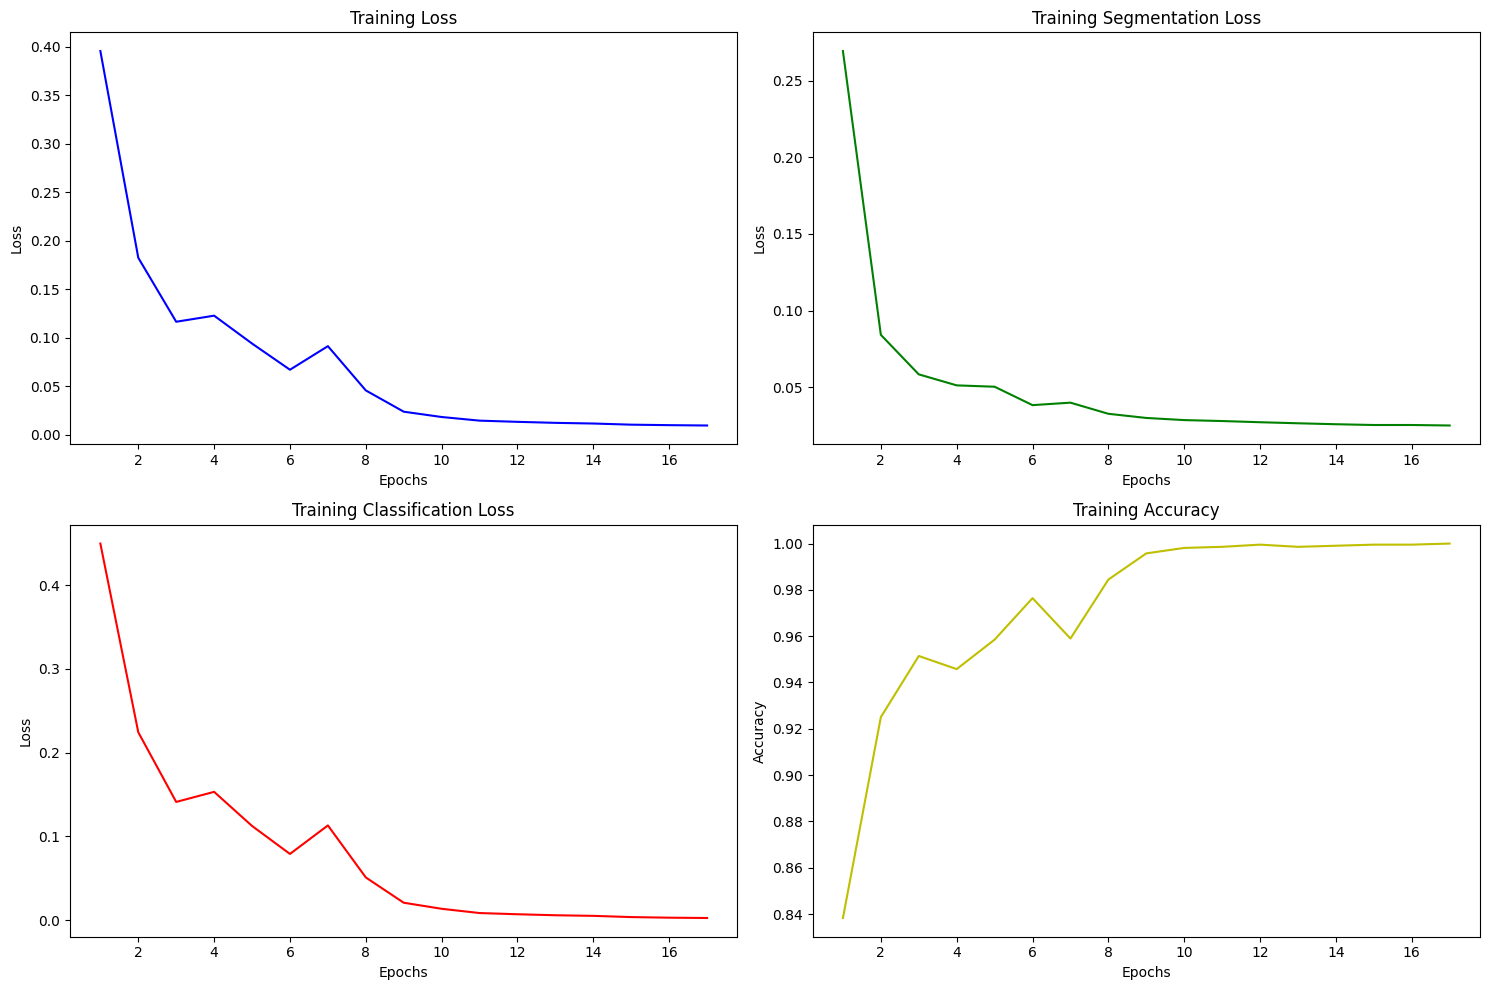

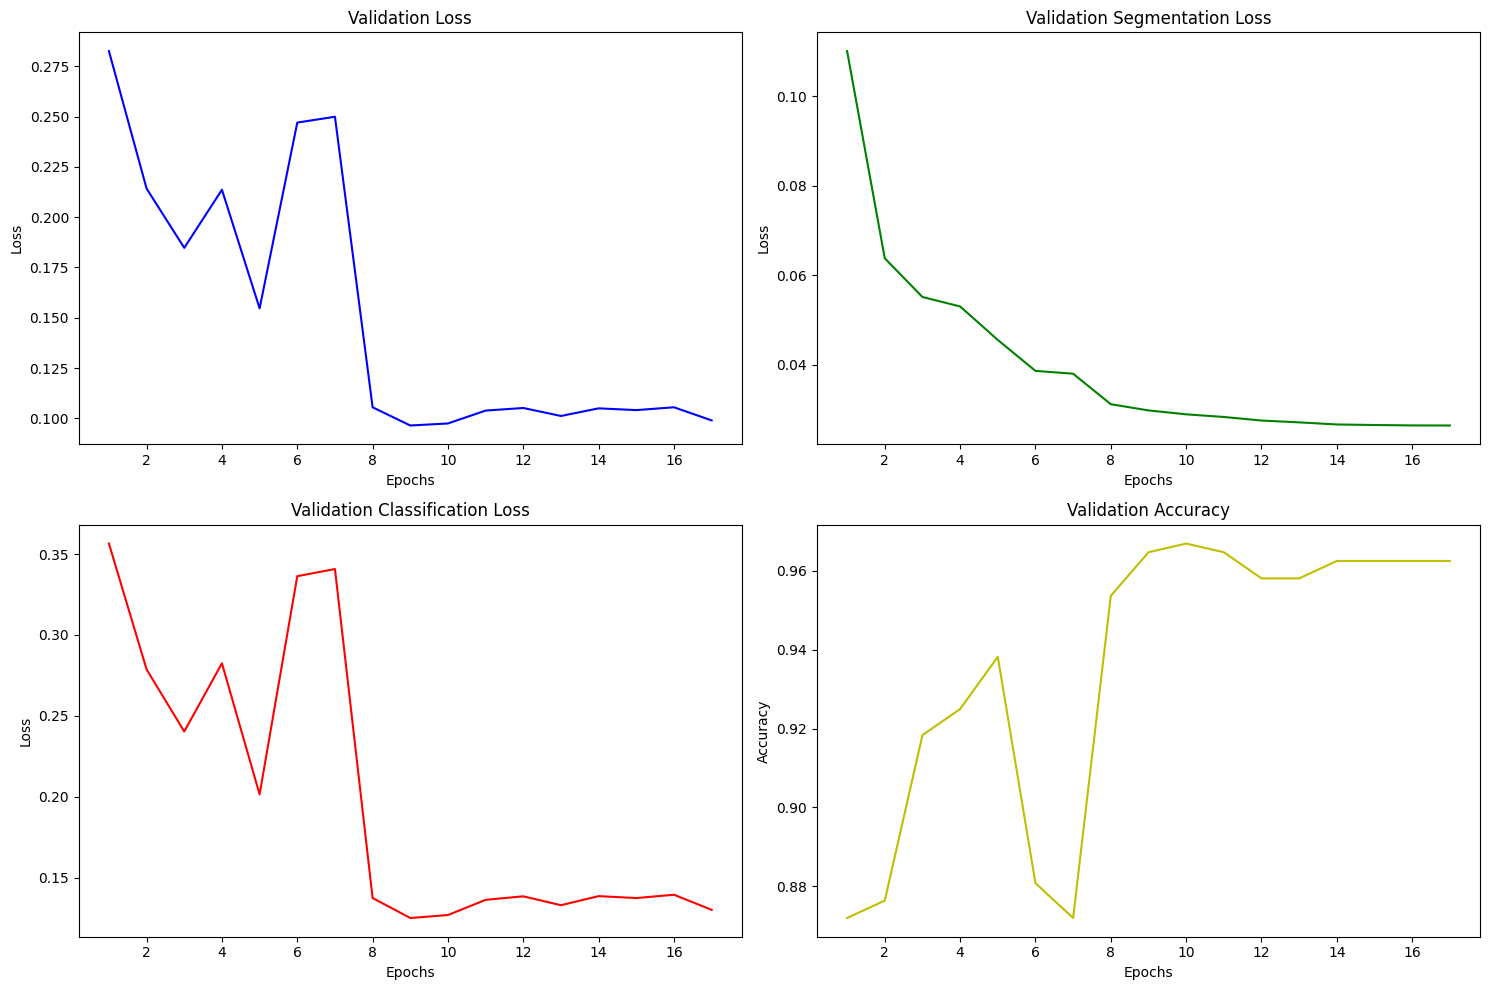

In [74]:
foward_pf, models = create_combined_model(num_classes=3)
segmentation_model, classification_model = models
params = list(segmentation_model.parameters()) + list(classification_model.parameters())
optimizer = optim.Adam(params, lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
for split, loader in dataloaders.items():
    print(f"{split}: {len(dataloaders.items())} samples")
print('Start Training...')
start_time = time.time()
best_states, history = train_model(
    foward_pf,
    models,
    dataloaders={k: v for k, v in dataloaders.items() if k in ['train', 'val']},
    optimizer = optimizer,
    loss_weight=[0.3, 0.7],
    scheduler=scheduler,
    num_epochs=25,
    patience=7
)
time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
for key, value in history.items():
    print(f"{key}: length = {len(value)}")
plot_training_history(history)
best_seg_state, best_cls_state = best_states
segmentation_model.load_state_dict(best_seg_state)
classification_model.load_state_dict(best_cls_state)
models_path = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Models'
torch.save(best_seg_state, os.path.join(models_path, 'best_seg_state.pth'))
torch.save(best_cls_state, os.path.join(models_path, 'best_cls_state.pth'))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       108
           1       1.00      0.93      0.96        40
           2       0.97      0.98      0.98       305

    accuracy                           0.96       453
   macro avg       0.97      0.95      0.96       453
weighted avg       0.97      0.96      0.96       453


Segmentation Results:
Mean Dice Coefficient: 0.9752


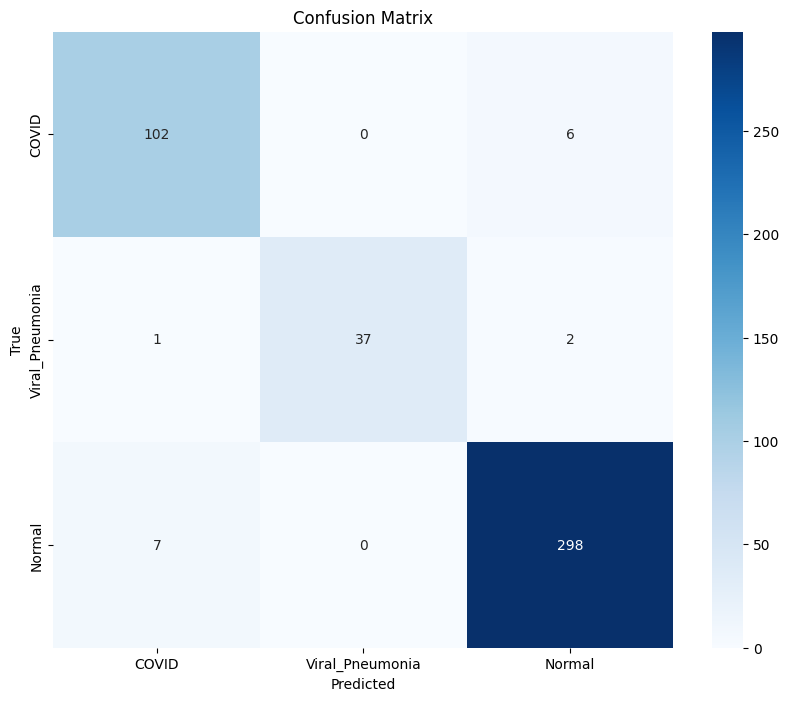

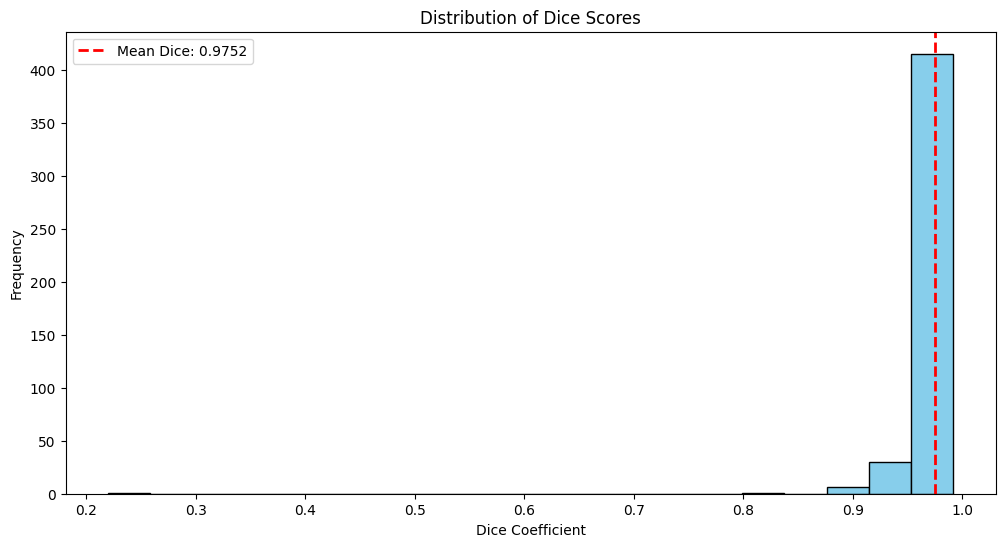

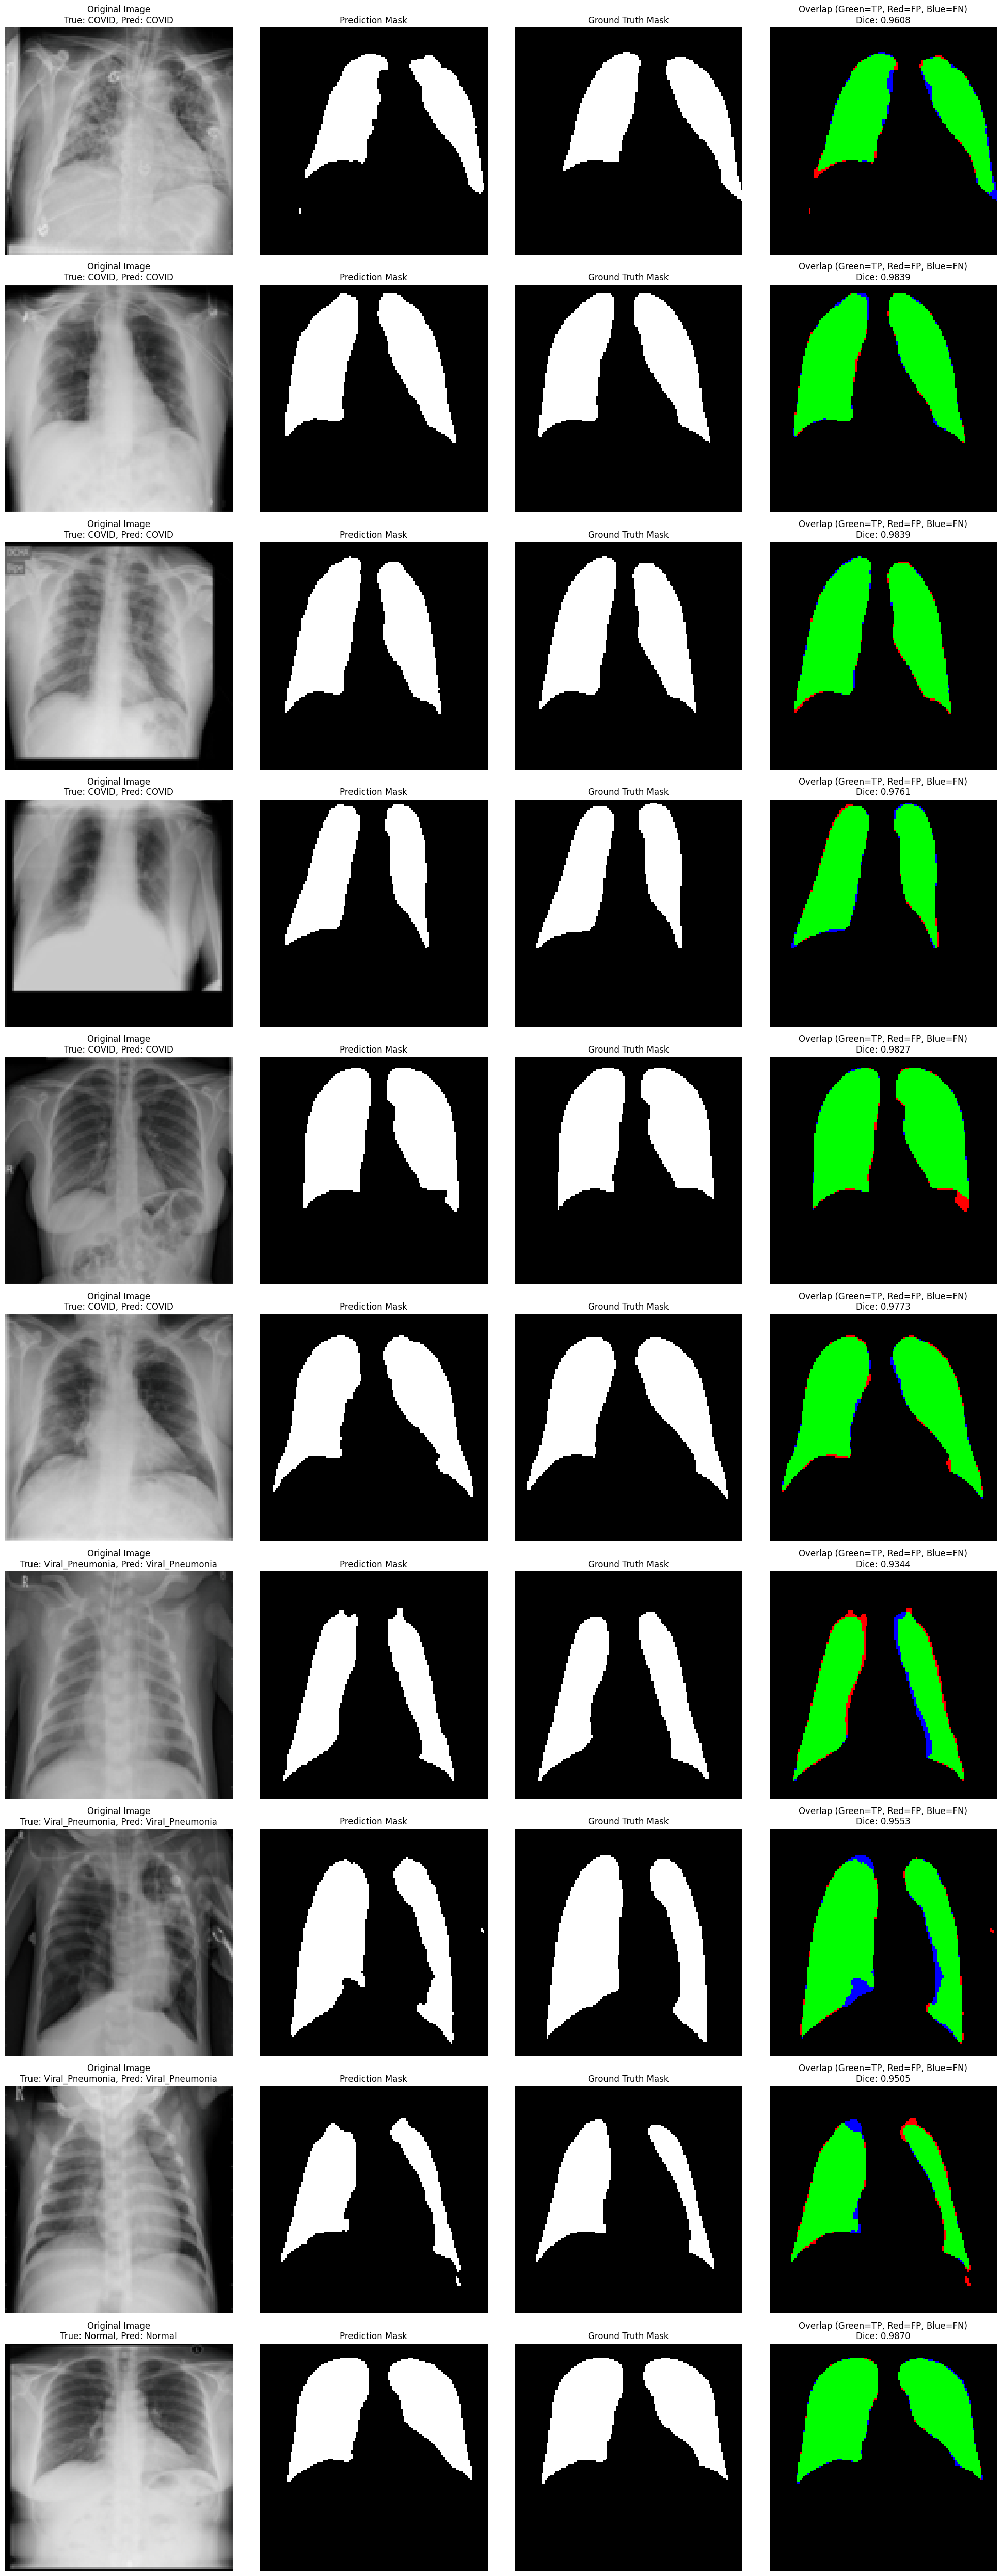

Classification Accuracy: 0.9647


In [79]:
evaluate_model(foward_pf, models)

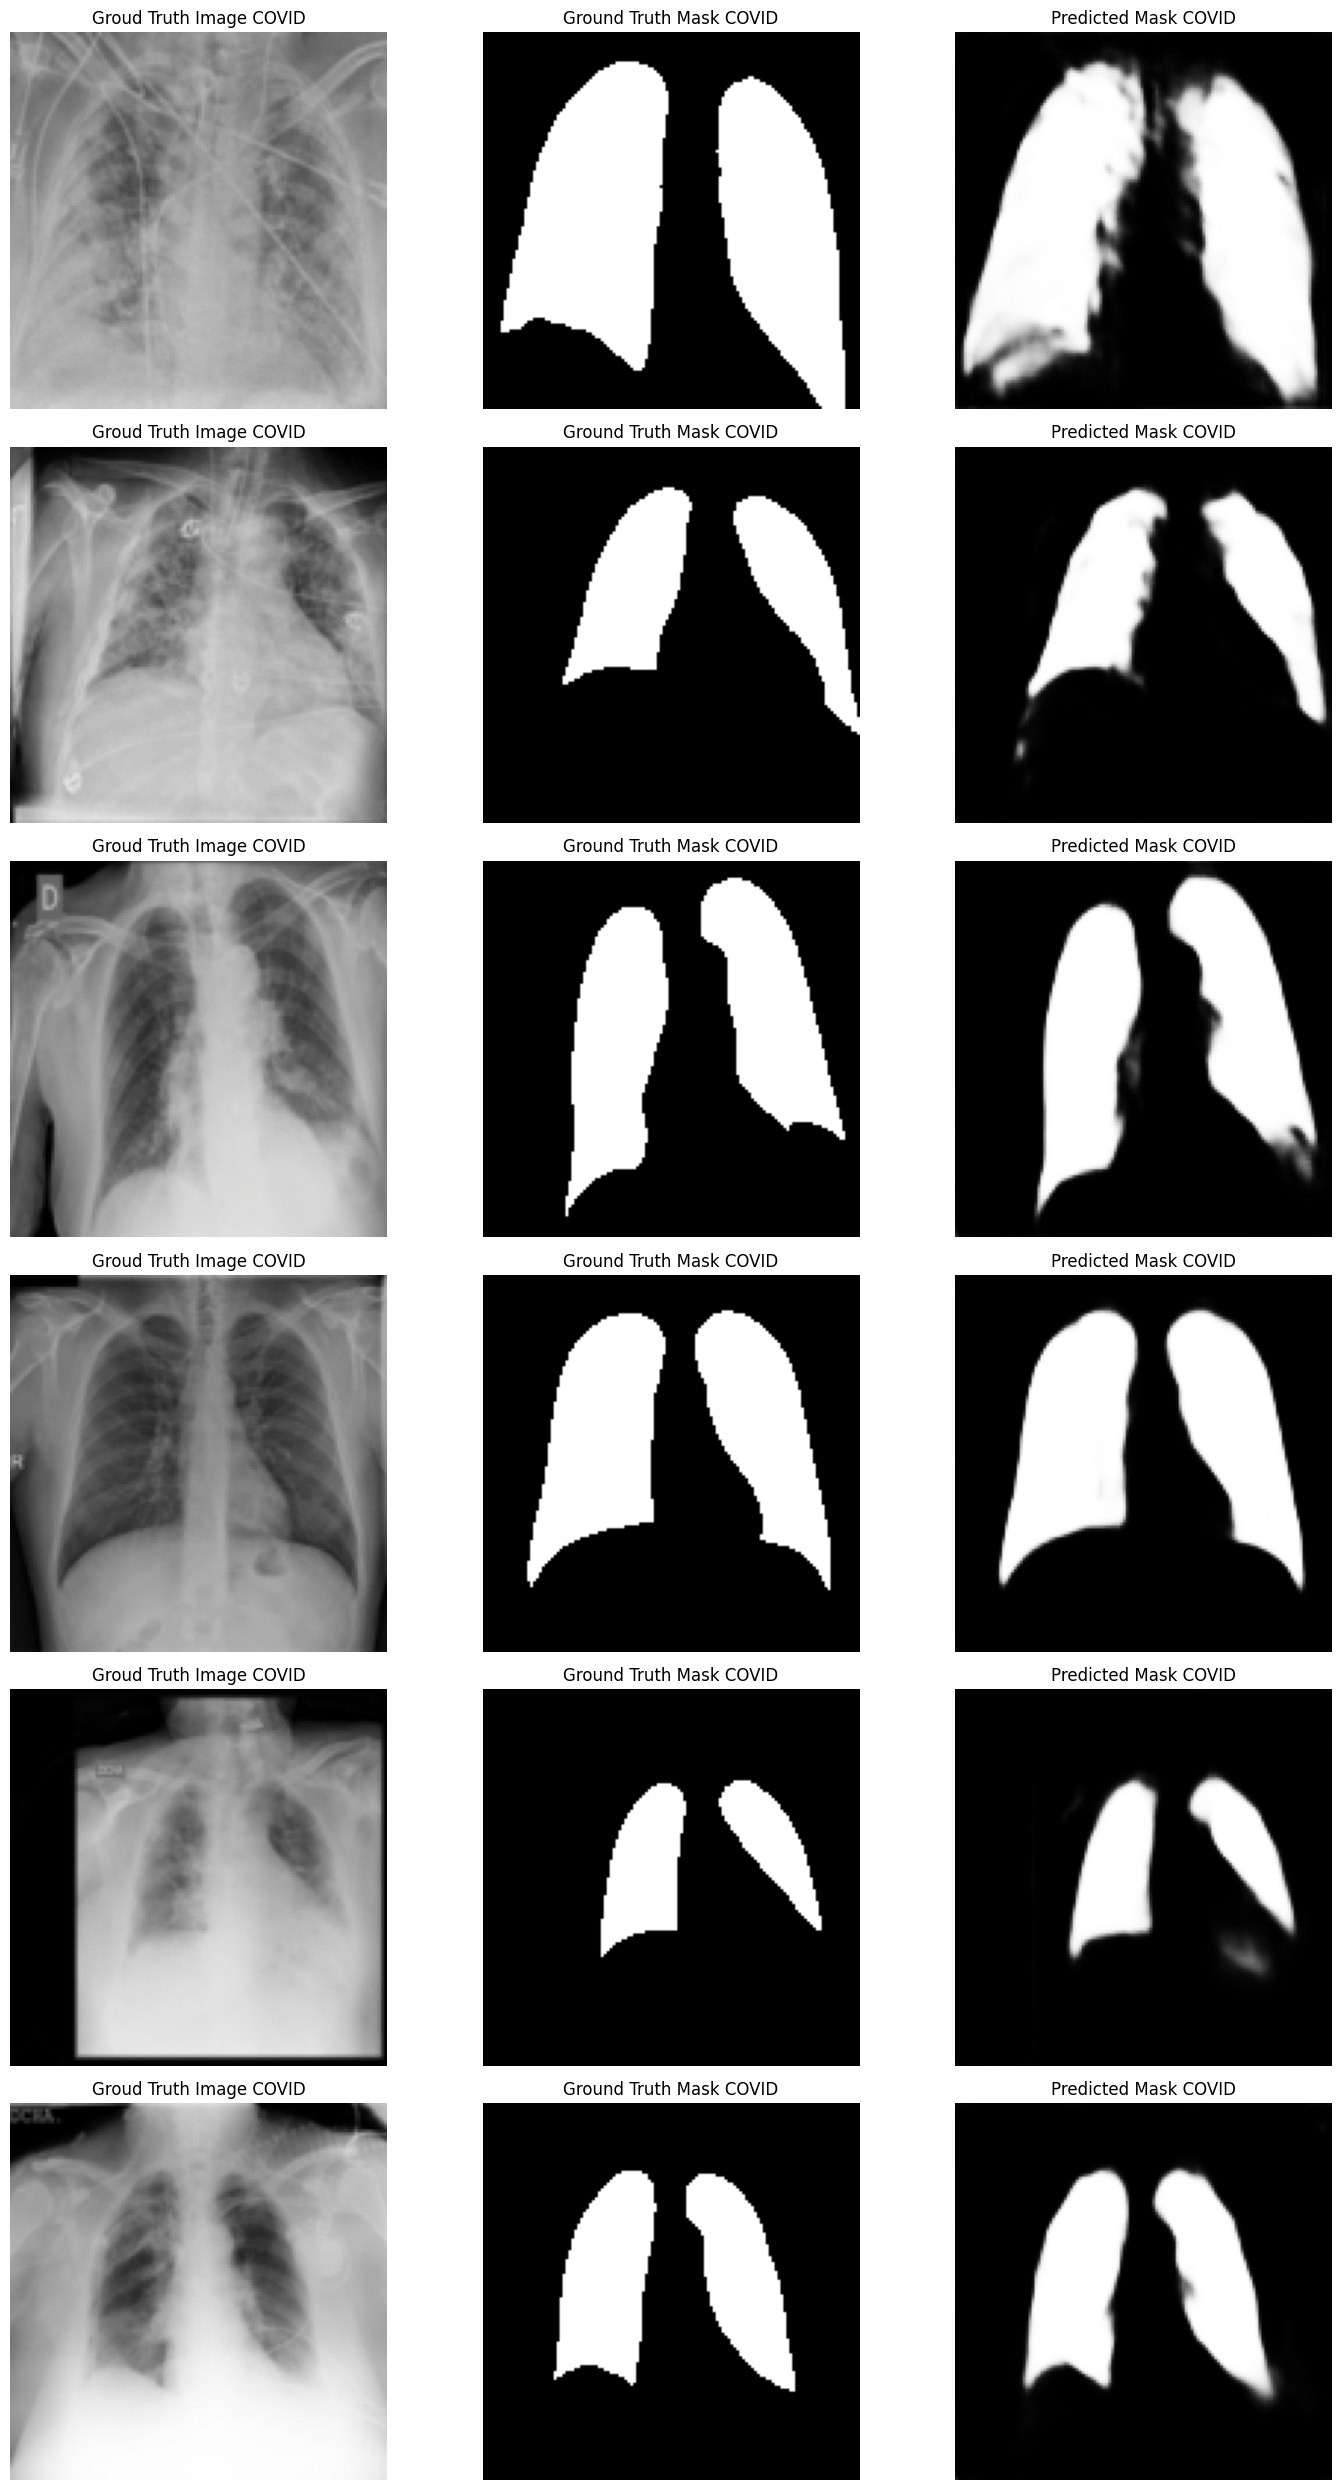

In [76]:
plot_predictions(foward_pf, models)

# Demo
This demo is for the video (maybe presentation if time allow). To run this demo first run the preparation and dataloading part. The function have to run is `create_combined_model`. Make sure attributes `mean`, `std`, `device` are defined.

Loading segmentation model: /content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Models/best_seg_state.pth
Loading classification model: /content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Models/best_cls_state.pth
Randomly selecting 3 images from the test set for demonstration


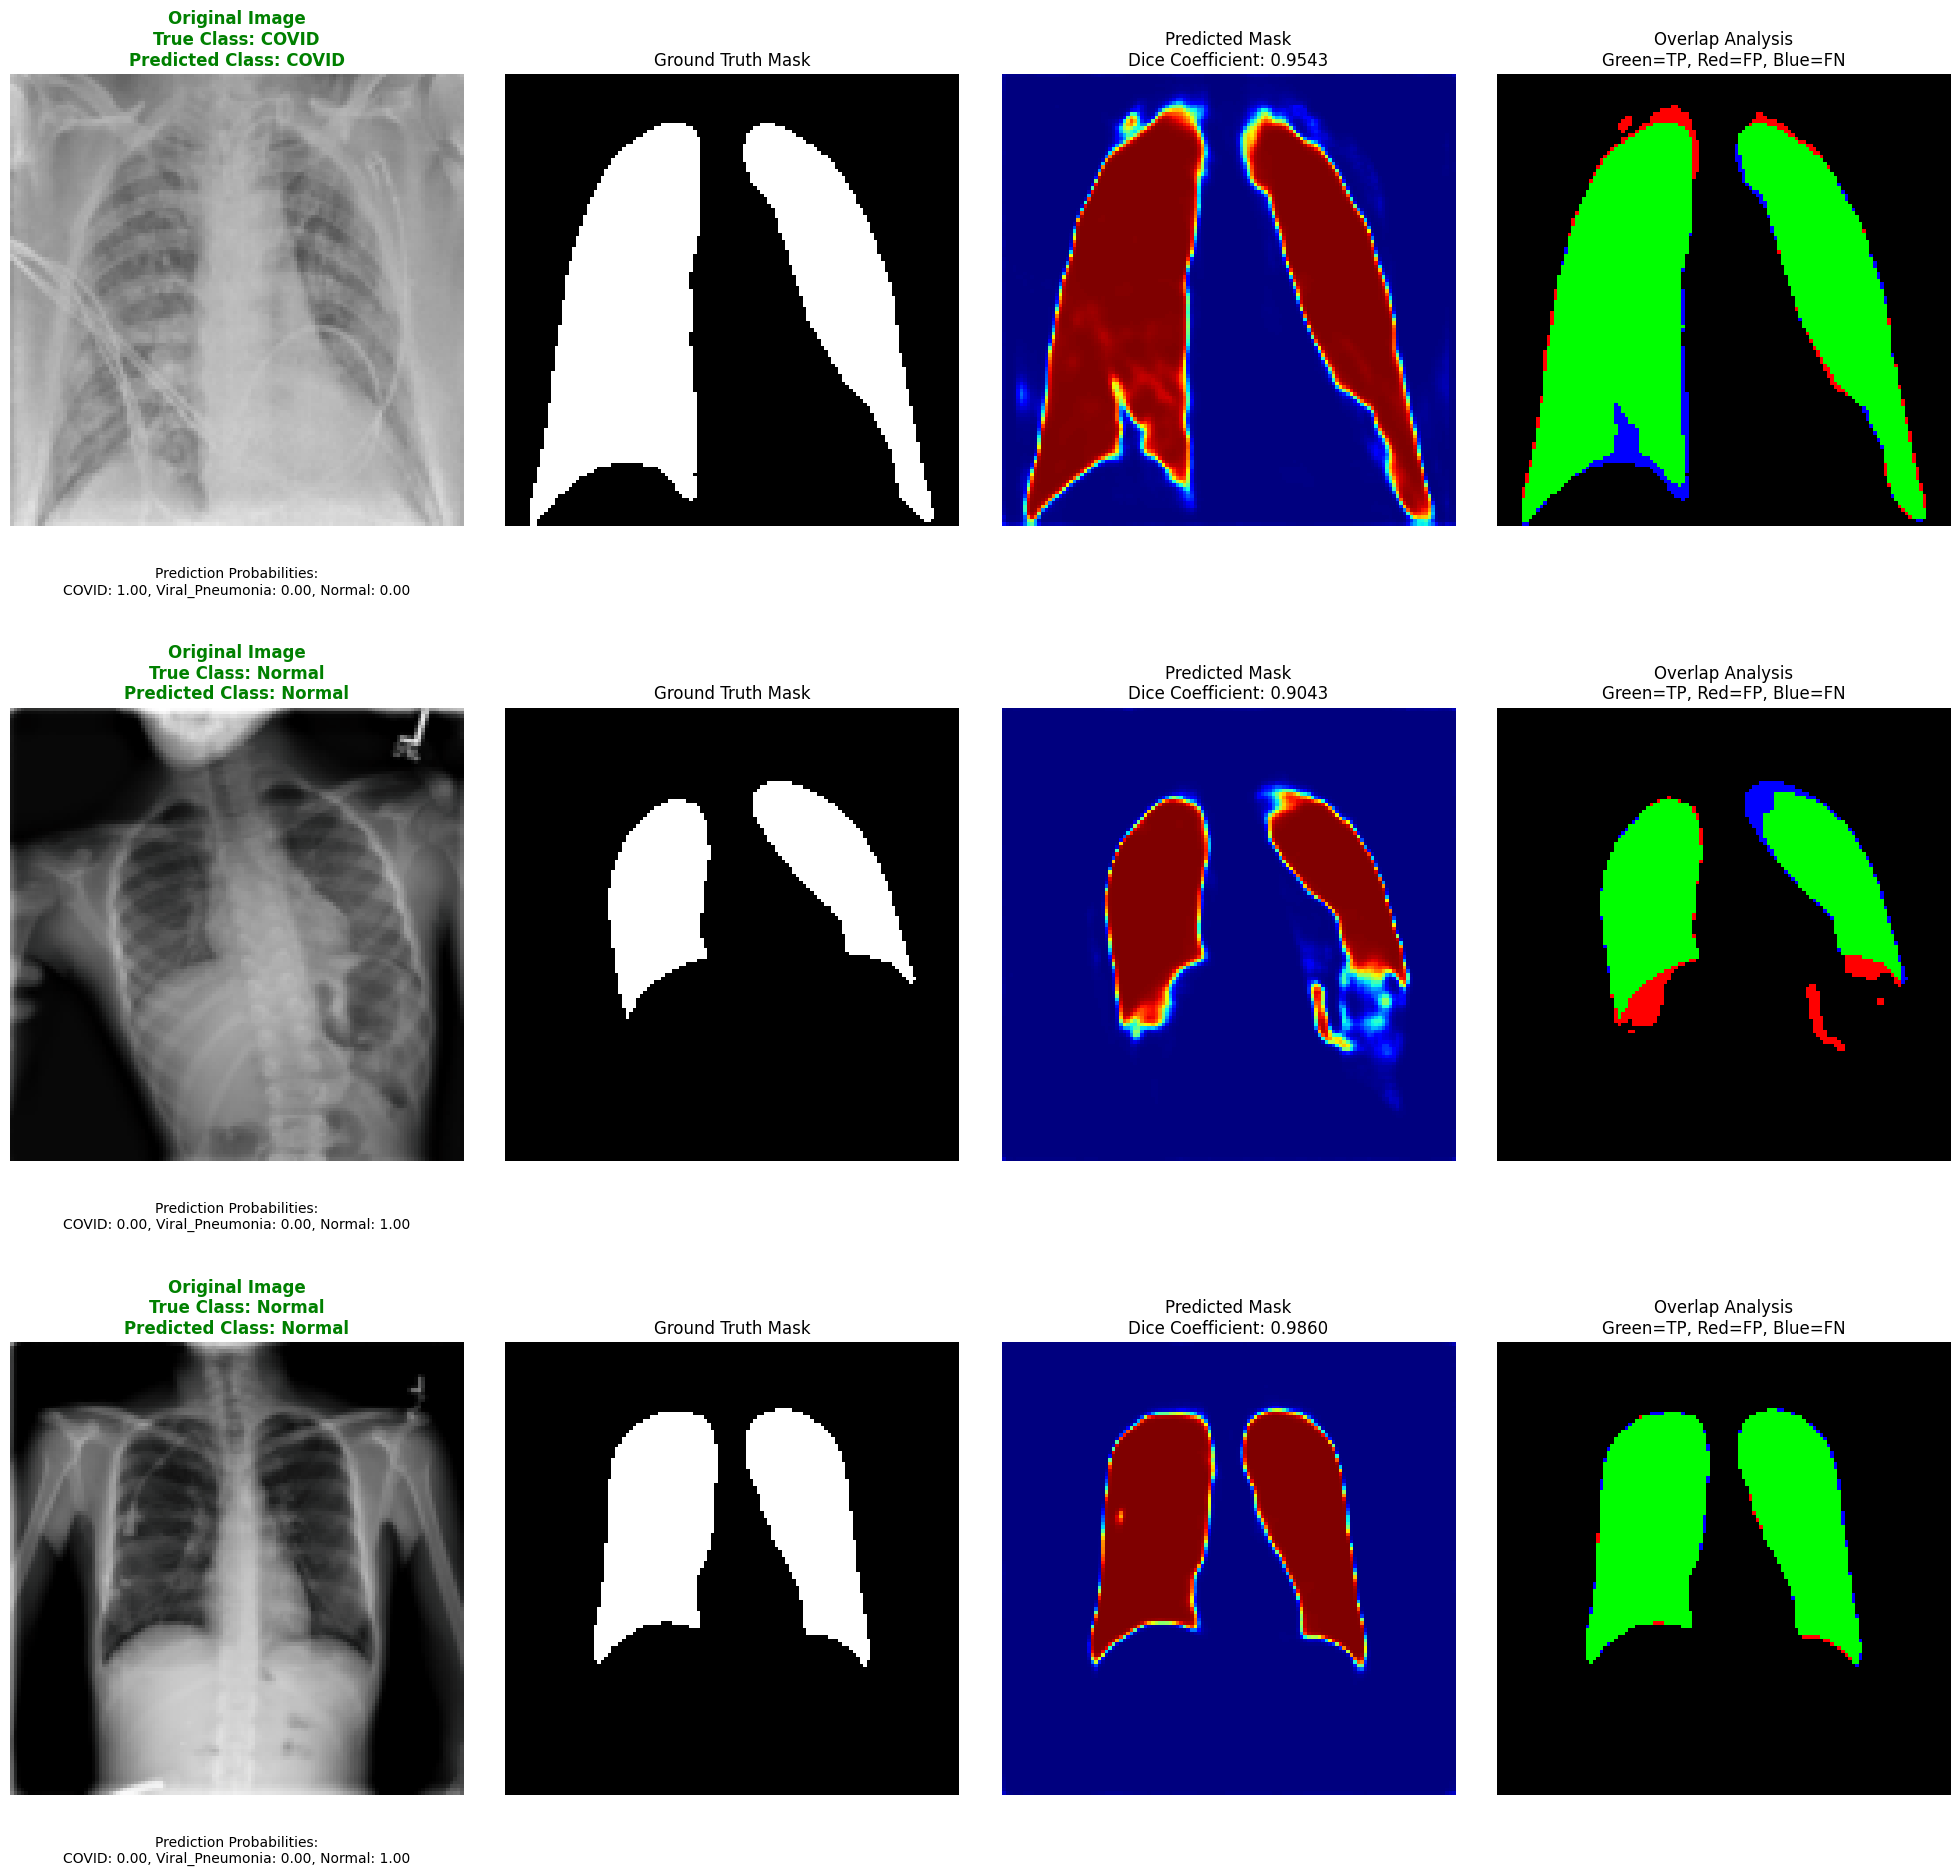


Model Performance Metrics (based on random samples):
Classification Accuracy: 1.00 (3/3)
Average Dice Coefficient: 0.9482


In [77]:
def visual_demo(seg_model_path, cls_model_path, num_samples=3):
    forward_fn, models = create_combined_model(num_classes=3)
    segmentation_model, classification_model = models
    print(f"Loading segmentation model: {seg_model_path}")
    print(f"Loading classification model: {cls_model_path}")
    map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    segmentation_model.load_state_dict(torch.load(seg_model_path, map_location=map_location))
    classification_model.load_state_dict(torch.load(cls_model_path, map_location=map_location))
    segmentation_model.eval()
    classification_model.eval()
    if 'test' in dataloaders:
        print(f"Randomly selecting {num_samples} images from the test set for demonstration")
        test_loader = dataloaders['test']
        all_data = []
        for inputs, masks, labels in test_loader:
            for i in range(inputs.size(0)):
                all_data.append((inputs[i], masks[i], labels[i]))
        selected_samples = random.sample(all_data, min(num_samples, len(all_data)))
        fig, axes = plt.subplots(num_samples, 4, figsize=(20, 6 * num_samples))
        if num_samples == 1:
            axes = np.array([axes])
        correct_classifications = 0
        total_dice = 0
        for i, (input_img, mask, label) in enumerate(selected_samples):
            input_img = input_img.unsqueeze(0).to(device)  # Add batch dimension
            true_mask = mask.to(device)
            true_label = label.to(device)
            with torch.no_grad():
                pred_mask, pred_logits = forward_fn(input_img)
                pred_probs = F.softmax(pred_logits, dim=1)
                _, pred_label = torch.max(pred_logits, 1)
            pred_mask_binary = (pred_mask > 0.5).float()
            true_mask_binary = (true_mask > 0.5).float()
            intersection = torch.sum(pred_mask_binary * true_mask_binary) * 2.0
            union = torch.sum(pred_mask_binary) + torch.sum(true_mask_binary)
            if union == 0:
                dice = 1.0 if intersection == 0 else 0.0
            else:
                dice = (intersection / union).item()
            total_dice += dice
            is_correct = (pred_label.item() == true_label.item())
            if is_correct:
                correct_classifications += 1
            mean_tensor = torch.tensor(mean, device='cpu').view(3, 1, 1)
            std_tensor = torch.tensor(std, device='cpu').view(3, 1, 1)
            img_display = input_img[0].cpu() * std_tensor + mean_tensor
            img_display = img_display.permute(1, 2, 0).numpy()
            true_mask_np = true_mask[0].cpu().numpy()
            pred_mask_np = pred_mask[0, 0].cpu().numpy()
            true_class = class_names[true_label.item()]
            pred_class = class_names[pred_label.item()]
            probs_dict = {class_names[j]: f"{prob:.2f}" for j, prob in enumerate(pred_probs[0].cpu().numpy())}
            probs_str = ", ".join([f"{k}: {v}" for k, v in probs_dict.items()])
            axes[i, 0].imshow(img_display)
            title_text = f"Original Image\nTrue Class: {true_class}\nPredicted Class: {pred_class}"
            title = axes[i, 0].set_title(title_text, fontsize=12)
            plt.setp(title, color='green' if is_correct else 'red', fontweight='bold')
            axes[i, 0].axis('off')
            axes[i, 0].text(0.5, -0.15, f"Prediction Probabilities:\n{probs_str}",
                           transform=axes[i, 0].transAxes,
                           ha='center', fontsize=10)
            axes[i, 1].imshow(true_mask_np, cmap='gray')
            axes[i, 1].set_title("Ground Truth Mask", fontsize=12)
            axes[i, 1].axis('off')
            axes[i, 2].imshow(pred_mask_np, cmap='jet')
            axes[i, 2].set_title(f"Predicted Mask\nDice Coefficient: {dice:.4f}", fontsize=12)
            axes[i, 2].axis('off')
            # Green=TP, Red=FP, Blue=FN
            overlap = np.zeros((img_display.shape[0], img_display.shape[1], 3))
            pred_binary = (pred_mask_np > 0.5)
            true_binary = (true_mask_np > 0.5)
            tp = np.logical_and(pred_binary, true_binary)
            overlap[tp, 1] = 1.0
            fp = np.logical_and(pred_binary, np.logical_not(true_binary))
            overlap[fp, 0] = 1.0
            fn = np.logical_and(np.logical_not(pred_binary), true_binary)
            overlap[fn, 2] = 1.0
            axes[i, 3].imshow(overlap)
            axes[i, 3].set_title("Overlap Analysis\nGreen=TP, Red=FP, Blue=FN", fontsize=12)
            axes[i, 3].axis('off')
            for j in range(4):
                for spine in axes[i, j].spines.values():
                    spine.set_color('green' if is_correct else 'red')
                    spine.set_linewidth(4)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.4)
        plt.show()
        # Overall performance metrics
        accuracy = correct_classifications / num_samples
        avg_dice = total_dice / num_samples
        print("\nModel Performance Metrics (based on random samples):")
        print(f"Classification Accuracy: {accuracy:.2f} ({correct_classifications}/{num_samples})")
        print(f"Average Dice Coefficient: {avg_dice:.4f}")
    else:
        print("Test set data not available, cannot run demonstration")

# Demo Executing
seg_model_path = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Models/best_seg_state.pth'
cls_model_path = '/content/drive/MyDrive/Projects/datasets/COVID-19_Radiography_Dataset/Models/best_cls_state.pth'
# Randomly select 3 images as samples from the testing dataset
visual_demo(seg_model_path, cls_model_path, num_samples=3)